In [30]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

from pylib.tensorboardcmd import tensorboard_cmd

In [32]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: images/VAE.png -->
<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/tensorboardcmd.py -->

# Variational Autoencoders

## Autoencoders

Autoencoders are neural networks where the number of input and output neurons are the same. If our input neurons represent pixels in an image, the output of our antoencoder will ideally be the input image. Why would we want to create a model that simply reproduces our data? If we restrict the number of neurons in our hidden layers to be less than the number of input or output neurons, we force our model to learn sparse representations of the data. Therefore, autoencoders can be used for image compression and removing noise from images. 

![VAE](images/VAE.png)

An autoencoder consists of two neural networks -- an **encoder** and **decoder**. The encoder takes in high dimensional data and generates low dimensional representations of that data. Then, the decoder takes the low dimensional representations and translates them back into the high dimensional input space. 

## Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) differ from regular autoencoders, because they not only learn sparse representations of data but also generate new data. Consequently, VAEs are used to [create new images](https://openai.com/blog/generative-models/). For example, we can train a VAE on the MNIST dataset and have it create an image of a handwritten "5." 

How do VAEs generate new data? They do so by making smart assumptions about the distributions of these sparse data representations, or **latent vectors**. More generally, they belong to a class of models called generative models, which learn the joint probability distribution between the input ($x$) and output (or latent vectors, $z$). We can then use this information to come up with likely $(x,z)$ pairs. For example, once we learn the distribution corresponding to the sparse representation of a handwritten "5," we can sample from this distribution to form new latent vectors for "5." 

Due to this constraint on the distributions of $z$, VAEs require an additional component in their loss function that penalizes deviations from these distributions.   

In this tutorial, we will build a simple VAE to recreate images in the MNIST dataset. We will start off as usual by resetting our session, loading our data, setting our variables, and defining our weights and biases functions. 

In [33]:
reset_tf()

# Load Data
data = input_data.read_data_sets('/tmp/data/', one_hot=True)

# Get classes for test data
data.test.cls = np.argmax(data.test.labels, axis=1)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [34]:
# Set the path to our summary logs
now = datetime.now()
logs_path = now.strftime("%Y%m%d-%H%M%S") + '/summaries'

In [35]:
# Set parameters
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

batch_size = 256
num_iterations = 400  # 1500
display_step = 100

In [36]:
# Set placeholders
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

## Encoder and decoder

As mentioned in above, VAEs make assumptions about the distribution of latent variables. Therefore, we will now consider VAEs from a probability framework. 

Recall **Bayes' Theorem** that tells us:

$$\begin{eqnarray}
P(z \mid x) &=& \frac{P(x \mid z) \cdot P(z)}{P(x)} \\
\\
\text{posterior distribution} &=& \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
\end{eqnarray}$$


Say we have data $x$ and latent variables $z$. The encoder tries to approximate the posterior distribution $P(z \mid x)$, or generate latent variables conditioned on the data. On the other hand, the decoder takes $z$ [sampled from $P(z \mid x)$] and outputs parameters to the likelihood distribution $P(x \mid z)$. These parameters are the weights and biases of the neural networks. 

Going back to the neural network framework, in the code below, our encoder and decoder are neural networks (of two layers each) that are mirrored images of each other. We feed the output of the encoder directly into the decoder. 

In [37]:
# Building the encoder
def encoder(x, out_sizes):
    for size in out_sizes:
        x = tf.layers.dense(x, size, activation=tf.nn.sigmoid, use_bias=True,
            kernel_initializer=tf.truncated_normal_initializer())
    return x

# Building the decoder
def decoder(x, out_sizes):
    # Reverse the sizes, skipping the smallest and adding a layer to return the original size
    out_sizes = out_sizes[-2::-1] + [img_size_flat]
    for size in out_sizes:
        x = tf.layers.dense(x, size, activation=tf.nn.sigmoid, use_bias=True,
            kernel_initializer=tf.truncated_normal_initializer())
    return x

out_sizes = [256, 128]

# Construct model
encoder_op = encoder(x, out_sizes)
decoder_op = decoder(encoder_op, out_sizes)

# Prediction
y_pred = decoder_op

# Targets (Labels) are the input data.
y_true = x

## KL-divergence

We want our network to be accurate, but we also want the latent variables to approximate the posterior distribution. The amount of information lost when approximating $P(z \mid x)$ is called the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), and we will use it to construct our loss function. To make our lives simple, we will choose the posterior distribution to be a unit normal and [calculate](http://allisons.org/ll/MML/KL/Normal/) the divergence accordingly. 

Why do we want our latent variables to approximate a certain distribution? We want them to be useful, so we impose this constraint. We can think of this as a form of  of regularization where we lose some fidelity to ensure we are capturing only important features. In other words, we want to build a model that can generate images and not just memorize them. A nice explanation of choosing latent variables can be found [here](http://kvfrans.com/variational-autoencoders-explained/).

We also want to minimize the loss due to inaccurate pixel values and must therefore create a component of the loss function that penalizes these errors. This component is called `generation_loss` in the code below, and it is the squared difference between the true and regenerated pixel values in our images. 

In [38]:
generation_loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

z_mean, z_var = tf.nn.moments(encoder_op, axes=[0], name='moments', keep_dims=True)
z_stddev = tf.sqrt(z_var)
kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)

loss = tf.reduce_mean(generation_loss + kl_loss)
#loss = tf.reduce_mean(generation_loss)
#loss = tf.reduce_mean(kl_loss)
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

## Adam optimizer

We also define an optimizer, but unlike last time, we will use the Adam Optimizer instead of the Gradient Descent Optimizer. This optimizer uses a decaying learning rate. 

As a reminder, we can interpret the learning rate as the size of the step we take down a gradient of our loss function. If the step size is too large, we may never get to the minimum. A large learning rate will manifest itself as noise in our loss curve that never converges to a minimum point. However, if we have a very small step size, our model may take a long time to run. Ideally, we want to take large steps at the start of the training process and small steps towards the end. The [Adam Optimizer](https://arxiv.org/pdf/1412.6980v8.pdf) changes the learning rate for us. 

In [39]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

As we have done in the previous model we built, we then merge our summaries and initialize and lunch the graph.

In [40]:
#Merge all summaries
merged = tf.summary.merge_all()

#Create summary writers
train_writer = tf.summary.FileWriter(logs_path + '/train', graph=tf.get_default_graph())

Then we will train our model.

In [41]:
def optimize(num_iterations):
    #Initialize
    reset_vars()

    # Start-time used for printing time-usage below.
    start_time = time.time()

    step = 1
    for i in range(num_iterations):
        
        # Get a batch of training examples.
        x_batch, y_batch = data.train.next_batch(batch_size)

        # ---------------------- TRAIN -------------------------
        # optimize model
        sess.run(optimizer, feed_dict={x: x_batch}) 
        
        
        # Print status every 100 iterations.
        if (i % display_step == 0) or (i == num_iterations - 1):
            
            summary, l = sess.run([merged, loss], feed_dict={x: x_batch})
            train_writer.add_summary(summary, step)
            
            # Message for network evaluation
            msg = "Optimization Iteration: {0:>6}, Train Loss: {1:>6}"
            print(msg.format(i, l))
            
            step += 1

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [42]:
optimize(num_iterations)

Optimization Iteration:      0, Train Loss: 184.263687134
Optimization Iteration:    100, Train Loss: 72.0878982544
Optimization Iteration:    200, Train Loss: 67.9514770508
Optimization Iteration:    300, Train Loss: 66.7629241943
Optimization Iteration:    399, Train Loss: 65.5155258179
Time usage: 0:00:16


We can view and evaluate our model on TensorBoard by running the command line below.

In [43]:
# Close summary writer
train_writer.close()

tensorboard_cmd(logs_path)

Finally we will regenerate 10 of the MNIST images. We will display the original test images above the regenerated ones. 

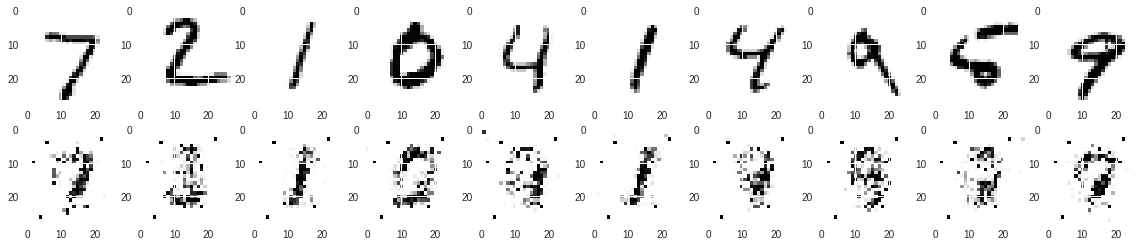

In [44]:
n_examples = 10

# Applying encode and decode over test set
encode_decode = sess.run(decoder_op, feed_dict={x: data.test.images[:n_examples]})

# Compare original images with their reconstructions
f, a = plt.subplots(2, n_examples, figsize=(20, 4))
for i in range(n_examples):
    a[0][i].imshow(np.reshape(data.test.images[i], img_shape))
    a[1][i].imshow(np.reshape(encode_decode[i], img_shape))

## Exercise: The influence of the loss functions

Rerun the code a couple more times, but remove one of the two loss components -- `generation_loss` and `kl_loss`. How do the results change?

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*